In [ ]:
from keras.datasets import imdb
import pandas as pd
import numpy as np
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ISR Dataset/IMDB Dataset.csv')

data['review'] = data['review'].str.lower()


In [ ]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because",
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here",
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should",
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [ ]:
def remove_stopwords(data):
  data['review without stopwords'] = data['review'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
  return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result


In [ ]:
data_without_stopwords = remove_stopwords(data)
data_without_stopwords['clean_review']= data_without_stopwords['review without stopwords'].apply(lambda cw : remove_tags(cw))
data_without_stopwords['clean_review'] = data_without_stopwords['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')

In [ ]:
data_without_stopwords.head()

,review,sentiment,review without stopwords,clean_review
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching just 1 oz epi...,one reviewers mentioned watching just 1 oz epi...
1,a wonderful little production. <br /><br />the...,positive,wonderful little production. <br /><br />the f...,wonderful little production the filming techn...
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...
3,basically there's a family where a little boy ...,negative,basically family little boy (jake) thinks zomb...,basically family little boy jake thinks zomb...
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love time money"" visually stu...",petter mattei s love time money visually stu...


In [ ]:

reviews = data_without_stopwords['clean_review']
reviews

0        one reviewers mentioned watching just 1 oz epi...
1        wonderful little production  the filming techn...
2        thought wonderful way spend time hot summer we...
3        basically family little boy  jake  thinks zomb...
4        petter mattei s  love time money  visually stu...
                               ...                        
49995    thought movie right good job  wasn t creative ...
49996    bad plot  bad dialogue  bad acting  idiotic di...
49997    catholic taught parochial elementary schools n...
49998    going disagree previous comment side maltin on...
49999    no one expects star trek movies high art  fans...
Name: clean_review, Length: 50000, dtype: object

In [ ]:
reviews_list = []
for i in range(len(reviews)):
  reviews_list.append(reviews[i])



In [ ]:
sentiment = data_without_stopwords['sentiment']

In [ ]:
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, sentiment)))

In [ ]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
X_train, X_test,Y_train, Y_test = train_test_split(reviews_list, y, test_size=0.2, random_state = 45)

In [ ]:
len(Y_train)

40000

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [ ]:
words_to_index = tokenizer.word_index

In [ ]:
len(words_to_index)

95419

In [ ]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)



  return word_to_vec_map


In [ ]:
word_to_vec_map = read_glove_vector('/content/drive/MyDrive/ISR Dataset/glove.6B.50d.txt')

In [ ]:
maxLen = 150


In [ ]:

vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)






In [ ]:
def imdb_rating(input_shape):

  X_indices = Input(input_shape)

  embeddings = embedding_layer(X_indices)

  X = LSTM(128, return_sequences=True)(embeddings)

  X = Dropout(0.6)(X)

  X = LSTM(128, return_sequences=True)(X)

  X = Dropout(0.6)(X)

  X = LSTM(128)(X)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [ ]:
model = imdb_rating((maxLen,))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           4770950   
_________________________________________________________________
lstm (LSTM)                  (None, 150, 128)          91648     
_________________________________________________________________
dropout (Dropout)            (None, 150, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584

In [ ]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

In [ ]:
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_train_indices.shape

(40000, 150)

In [ ]:
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit(X_train_indices, Y_train,validation_split=0.2, batch_size=64, epochs=15)

Epoch 1/15
500/500 [==============================] - 37s 30ms/step - loss: 0.6498 - accuracy: 0.5959 - val_loss: 0.5216 - val_accuracy: 0.7510
Epoch 2/15
500/500 [==============================] - 14s 28ms/step - loss: 0.5192 - accuracy: 0.7501 - val_loss: 0.4923 - val_accuracy: 0.7714
Epoch 3/15
500/500 [==============================] - 14s 28ms/step - loss: 0.4835 - accuracy: 0.7730 - val_loss: 0.4725 - val_accuracy: 0.7807
Epoch 4/15
500/500 [==============================] - 14s 28ms/step - loss: 0.4575 - accuracy: 0.7848 - val_loss: 0.4463 - val_accuracy: 0.7906
Epoch 5/15
500/500 [==============================] - 14s 28ms/step - loss: 0.4369 - accuracy: 0.7981 - val_loss: 0.4243 - val_accuracy: 0.8073
Epoch 6/15
500/500 [==============================] - 14s 28ms/step - loss: 0.4221 - accuracy: 0.8088 - val_loss: 0.3980 - val_accuracy: 0.8251
Epoch 7/15
500/500 [==============================] - 14s 28ms/step - loss: 0.3914 - accuracy: 0.8279 - val_loss: 0.3972 - val_accuracy:

In [ ]:
import matplotlib.pyplot as plt

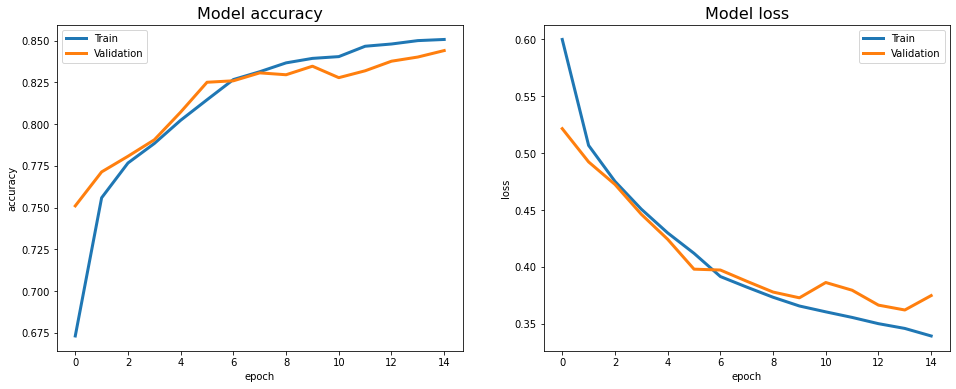

In [ ]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [ ]:
X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

In [ ]:
model.evaluate(X_test_indices,Y_test)

313/313 [==============================] - 5s 12ms/step - loss: 0.3686 - accuracy: 0.8426


[0.3686337172985077, 0.8425999879837036]

In [ ]:
preds = model.predict(X_test_indices)

In [ ]:
n = np.random.randint(0,9999)

X_test[n]


'meteor crashes crater lake  heat impact causing prehistoric egg hatch alright  plot just trash  despite obvious low budget  comes across one gripping entertaining monster on the loose films existence  also good moments humor  age filled so called  monsters  no laughable men in rubber suit creations lizards dressed frills forced rip pieces  cheap exploitation style   refreshing discover plesiosaur little gem excellent harryhausen style stop motion creature quite hard film find  worth finding '

In [ ]:
if preds[n] > 0.5:
  print('predicted sentiment : positive')
else:
  print('precicted sentiment : negative')

if (Y_test[n] == 1):
  print('correct sentiment : positive')
else:
  print('correct sentiment : negative')


predicted sentiment : positive
correct sentiment : positive


In [ ]:
preds[n]

array([0.95161897], dtype=float32)

In [ ]:
Y_test[n]

1

In [ ]:
reviews_list_idx = tokenizer.texts_to_sequences(reviews_list)

In [ ]:
def add_score_predictions(data, reviews_list_idx):

  data['sentiment score'] = 0

  reviews_list_idx = pad_sequences(reviews_list_idx, maxlen=maxLen, padding='post')

  review_preds = model.predict(reviews_list_idx)

  data['sentiment score'] = review_preds

  pred_sentiment = np.array(list(map(lambda x : 'positive' if x > 0.5 else 'negative',review_preds)))

  data['predicted sentiment'] = 0

  data['predicted sentiment'] = pred_sentiment

  return data



In [ ]:
data = add_score_predictions(data, reviews_list_idx)

In [ ]:
data

,review,sentiment,review without stopwords,clean_review,sentiment score,predicted sentiment
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching just 1 oz epi...,one reviewers mentioned watching just 1 oz epi...,0.479958,negative
1,a wonderful little production. <br /><br />the...,positive,wonderful little production. <br /><br />the f...,wonderful little production the filming techn...,0.991286,positive
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...,0.991914,positive
3,basically there's a family where a little boy ...,negative,basically family little boy (jake) thinks zomb...,basically family little boy jake thinks zomb...,0.025140,negative
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love time money"" visually stu...",petter mattei s love time money visually stu...,0.993747,positive
...,...,...,...,...,...,...
49995,i thought this movie did a down right good job...,positive,thought movie right good job. wasn't creative ...,thought movie right good job wasn t creative ...,0.918343,positive
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative,"bad plot, bad dialogue, bad acting, idiotic di...",bad plot bad dialogue bad acting idiotic di...,0.004684,negative
49997,i am a catholic taught in parochial elementary...,negative,catholic taught parochial elementary schools n...,catholic taught parochial elementary schools n...,0.455533,negative
49998,i'm going to have to disagree with the previou...,negative,going disagree previous comment side maltin on...,going disagree previous comment side maltin on...,0.859078,positive


In [ ]:
z_original = np.array(list(map(lambda x: 1 if x=="positive" else 0, data.sentiment)))

In [ ]:
z_predicted= np.array(list(map(lambda x: 1 if x=="positive" else 0, data['predicted sentiment'])))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
matrix = confusion_matrix(z_original,z_predicted, labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(z_original,z_predicted,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(z_original,z_predicted,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[22141  2859]
 [ 4529 20471]]
Outcome values : 
 22141 2859 4529 20471
Classification report : 
               precision    recall  f1-score   support

           1       0.83      0.89      0.86     25000
           0       0.88      0.82      0.85     25000

    accuracy                           0.85     50000
   macro avg       0.85      0.85      0.85     50000
weighted avg       0.85      0.85      0.85     50000



In [ ]:
import seaborn as sb

In [ ]:
def plot_confusion_matrix(z_original, z_predicted, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(z_original,z_predicted)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

"plot_confusion_matrix(y_test, y_test_pred, ax=axis2,\n                      title='Confusion matrix (test data)',\n                      class_names=['Positive', 'Negative'])"

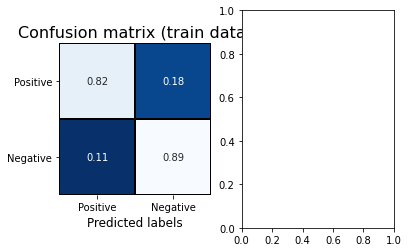

In [ ]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(z_original, z_predicted, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
'''plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])'''